In [2]:
import numpy as np
import time
from scipy import misc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
# import cvxpy as cp
from scipy.optimize import fsolve
import torch.optim.lr_scheduler as lr_scheduler

In [3]:
M=2000
ite=10
dim_n=3
T=1
T_C=1
T_F=0.1
delta_c = torch.tensor(T_C/ite)
delta_f=torch.tensor(T_F/ite)
print(delta_c,delta_f)
sigma=0.2
mu=0.3
A0=0.0
gamma=0.0
kappa=1.0
rho=5
X0=10000
neuron_model_psi=20

tensor(0.1000) tensor(0.0100)


In [4]:
model_f= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    torch.nn.ReLU(),
    #torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    #torch.nn.ReLU(),
    # torch.nn.Linear(neuron_model_psi, neuron_model_psi_2),
    # torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [5]:
#torch.save(model, 'model_N10.pth')
model_coarse = torch.load('model_N10_best.pth')
#model_coarse.eval()(c)

In [6]:
def update(x3,psi,delta):
  t=x3[:,0]+delta
  #print(psi.squeeze(1).shape,x1[:,1].shape)
  D = (x3[:,1]+kappa*psi)*torch.exp(-rho*delta)
  R= x3[:,2]-psi
  #print(R.shape)
  up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1)),dim=1)
  #print('up shape=', up.shape)
  return up

def loss_func(x2,psi):
  loss=(x2[:,1]*psi+(kappa/2.0)*torch.pow(psi,2))
  return loss

def unit(x1,model,delta):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi,delta)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(u,model,delta):
  loss=torch.zeros(M,ite+1)
  psi=torch.zeros(M,ite+1)
  for i in range(ite+1):
    if(i!=ite):
        psi_run,loss_run,u_run=unit(u,model,delta)
        #print('los func=',psi_run.shape,loss_run.shape)
        loss[:,i]=loss_run
        #print(loss)
        psi[:,i]=psi_run
        #print(psi)
        u=u_run
    #print(u)
    else:
    #print(torch.sum(psi,dim=1),R.squeeze(1))
        psi_ter=R.squeeze(1)-torch.sum(psi,dim=1)
        loss_ter=loss_func(u,psi_ter)
      #print('ter',loss_ter.shape)
  #print(torch.sum(loss,dim=1))
  #loss1=torch.sum(loss,dim=1)
  loss1=torch.sum(loss,dim=1)+loss_ter
  #print(loss.shape)
  return torch.mean(loss1)

In [7]:
def testing_coarse(X0,M1):    
    t_test=torch.zeros([M1,1])
    D_test=torch.zeros([M1,1])
    #D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
    #R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
    R_test=torch.linspace(X0*0.90, X0*1.1, steps=M1).unsqueeze(1)
    x_test=torch.cat((t_test,D_test,R_test),dim=1)
    #print('Input=',x_test,'\n')
    a=torch.zeros(M1,ite+1)
    #print(a.shape)
    for i in range(ite+1):
      if(i!=ite):
        #print(x_test)
        soln_pred=model_coarse.eval()(x_test).squeeze(1).detach()
        a[:,i]=soln_pred
        x_test=update(x_test,soln_pred,delta_c)
        #print(x_test,'\n')
      else:
        a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)

    x1=R_test.squeeze().numpy()
    t_soln=np.zeros((M1,ite+1))
    return x_test,a

#     for i in range(M1):
#       print('size of total order=',x1[i])

    #   num_soln,num_cost=numeric_soln(x1[i],ite+1)
    #   n_soln[i,:]=num_soln
    #   print('Numeric_soln',num_soln,'sum of all execution=',np.sum(num_soln))
    #   print('Numeric_cost=',num_cost,'\n')
    #   c_num[i]=num_cost

    #   t_soln[i,:]=closed_form(x1[i])
    #   print('closed form soln=',t_soln[i,:],'sum of all execution=',np.sum(t_soln[i,:]))
    #   true_cost=closed_cost(t_soln[i,:])
    #   c_true[i]=true_cost
    #   print('Closed form cost=',true_cost,'\n')

      #print('predicted soln=',a[i,:],'sum of all execution=',torch.sum(a[i,:]).detach())
    #   pred_cost=predicted_cost(a[i,:])
    #   print('predicted cost=',pred_cost.detach().numpy(),'\n')
    #   c_pred[i]=pred_cost
    # print(x_test,a)
    # print(torch.min(a),torch.min(x_test[:,1]))

In [8]:
x_c,c_soln=testing_coarse(X0,5)
# print(c_soln.shape)
# print(x_c,c_soln,torch.sum(a,1))
D_max=torch.max(x_c[:,1])
R_min=torch.min(c_soln)
R_max=torch.max(c_soln)
t=torch.zeros([M,1])
D=torch.FloatTensor(M,1).uniform_(0.0,D_max)
#D=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
R=torch.FloatTensor(M,1).uniform_(R_min,R_max)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
x=torch.cat((t,D,R),dim=1)
print('coarse soution=',c_soln[0])

coarse soution= tensor([1622.8436,  643.2346,  639.1348,  639.1675,  639.4049,  639.8301,
         640.4523,  641.2708,  642.2849,  643.3633, 1609.0137])


In [9]:
start=time.time()
lr1 = 8e-3
max_epoch = 8000
optimizer = optim.Adam(model_f.parameters(), lr1)

#print(psi.shape)
for epoch in range(max_epoch):
  optimizer.zero_grad()
  cost=loss_func_total(x,model_f,delta_f)
  cost.backward()
  optimizer.step()
  #print(loss.item())
  if (epoch % 100==0):
    print("At epoch {} the mean error is {:,}.".format(epoch,cost.detach()))
end=time.time()
print('time elapsed=',end-start)

At epoch 0 the mean error is 1627420.875.
At epoch 100 the mean error is 1329375.5.
At epoch 200 the mean error is 1328984.625.
At epoch 300 the mean error is 1328797.125.
At epoch 400 the mean error is 1328625.0.


KeyboardInterrupt: 

In [10]:
# torch.save(model_f, 'model_N10_fine.pth')
model_fin = torch.load('model_N10_fine.pth')
#model_fin=model_f

In [11]:
def closed_form(X,ite):
  alpa=np.exp(-rho*T/ite)
  p=np.zeros(ite+1)
  p[0]=X/((ite-1)*(1-alpa)+2)
  p[ite]=X/((ite-1)*(1-alpa)+2)
  for j in range(1,ite):
    p[j]=p[0]*(1-alpa)
  return p

def cost(y,ite):
  cost1=0.0
  D1=0.0
  for i in range(ite+1):
    cost1+=D1*y[i]+(kappa/2.0)*np.power(y[i],2)
    D1=(D1+kappa*y[i])*np.exp(-rho*T/ite)
  return cost1

In [12]:
def testing_fine_forward(c_soln,ite):    
    f_soln=[]
    c=c_soln[2]
    x_test=torch.tensor([[0.0,0.0,c[0]]])
    for i in range(ite+1):
        if (i!=0):
            x_test[0,2]=x_test[0,2]+c[i] #Adding previous remaining balance to the current balance
        if (i!=ite):         
            for j in range(ite):
                #print(i,x_test)
                soln_pred=model_fin.eval()(x_test).squeeze(1).detach()
                f_soln.append(soln_pred)
                x_test=update(x_test,soln_pred,delta_f)
            #print(x_test[0,2])
    f_soln.append(x_test[0,2].view(1))
    f_soln= np.array([tensor.numpy() for tensor in f_soln]).reshape(len(f_soln))
    return f_soln


# Results from forward pass

In [13]:
coarse_soln=c_soln[2].numpy()
print('coarse soln',coarse_soln, 'Total=',np.sum(coarse_soln))
fine_soln=testing_fine_forward(c_soln,ite)
true_soln=closed_form(10000,100)
print('\nFine solution=', fine_soln, 'Total=',np.sum(fine_soln))

coarse soln [1802.9597   714.56946  709.6252   709.4345   709.44775  709.6463
  710.0404   710.6294   711.4126   712.2576  1799.9766 ] Total= 9999.999

Fine solution= [ 768.191      36.690067   34.917553   33.277653   31.758312   30.348665
   29.038826   27.819923   26.683962   25.62364   207.29706    48.0205
   43.86402    41.69787    39.695374   37.841606   36.123062   34.527554
   33.044132   31.662811  199.53253    54.1967     49.771965   47.301815
   45.018333   42.904526   40.94497    39.12579    37.43448    35.859646
  186.96156    59.174545   54.597527   51.876877   49.362053   47.034164
   44.876396   42.873337   41.011154   39.27733   176.22055    63.240032
   58.56882    55.6395     52.93198    50.426014   48.10333    45.947456
   43.943363   42.077675  167.01622    66.576996   61.857574   58.752934
   55.883663   53.228275   50.76742    48.483482   46.36068    44.384636
  159.06006    69.3329     64.60181    61.348442   58.34204    55.56017
   52.982388   50.590256   48.367

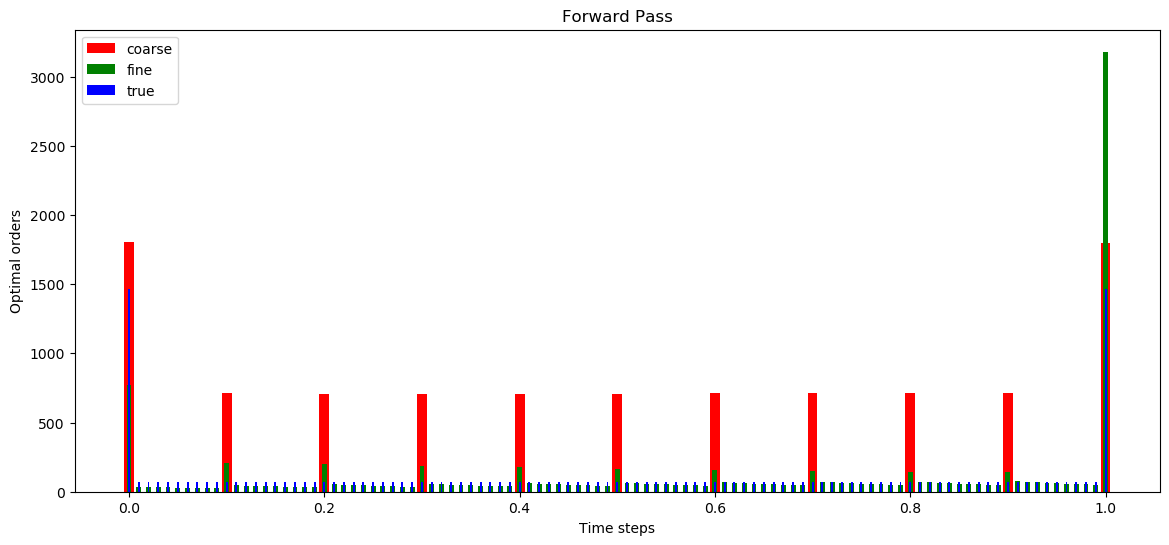

In [14]:
t_step1=np.linspace(0,1,num=11)
t_step2=np.linspace(0,1,num=101)
plt.figure(figsize=(14,6))
plt.bar(t_step1,coarse_soln,color='red',width=0.01,label='coarse')
plt.bar(t_step2,fine_soln,color='green',width=0.005,label='fine')
plt.bar(t_step2,true_soln,color='blue',width=0.002,label='true')
plt.xlabel('Time steps')
plt.ylabel('Optimal orders')
plt.title('Forward Pass')
plt.legend()
plt.show()


In [15]:
true_cost=cost(true_soln,100)
fine_cost=cost(fine_soln,100)
print('True Cost= %0.2f'% true_cost, 'Fine grid cost= %0.2f'% fine_cost)
error=np.abs(true_cost-fine_cost)
per_error=100*error/true_cost
print('Cost Error= %0.2f'% error)
print('Percentage error= %0.2f'% per_error,'%' )
D_N=data[0,2].detach().numpy()
derivative=kappa*(fine_soln[0])-((10000-sum(fine_soln[i] for i in range(len(fine_soln)-1)))+D_N)
print('\nDerivative of loss with respect to x0 =',derivative)

True Cost= 14287839.92 Fine grid cost= 16237057.78
Cost Error= 1949217.86
Percentage error= 13.64 %


NameError: name 'data' is not defined

# Strategy 2 (Adding two consecutive terms to predict the block)

In [16]:
def testing_fine_first_last(c_soln,ite):    
    f_soln=[]
    c=c_soln[2]
    x_test=torch.tensor([[0.0,0.0,c[0]]])
    #x_test[0,2]=x_test[0,2]+c[ite]
    for i in range(ite):       
        x_test[0,2]=x_test[0,2]+c[i+1] #Adding previous remaining balance to the current balance         
        for j in range(ite):
            #print(i,x_test)
            soln_pred=model_fin.eval()(x_test).squeeze(1).detach()
            f_soln.append(soln_pred)
            x_test=update(x_test,soln_pred,delta_f)
            #print(x_test[0,2])
    f_soln.append(x_test[0,2].view(1))
    f_soln= np.array([tensor.numpy() for tensor in f_soln]).reshape(len(f_soln))
    return f_soln

In [17]:
fine_soln=testing_fine_first_last(c_soln,ite)
true_soln=closed_form(10000,100)
print('\nFine solution=', fine_soln, fine_soln.shape,'Total=',np.sum(fine_soln))
print('\nDifference between true and fine=',(fine_soln-true_soln))
D_N=data[0,2].detach().numpy()
derivative=kappa*(fine_soln[0])-((10000-sum(fine_soln[i] for i in range(len(fine_soln)-1)))+D_N)
print('\nDerivative of loss with respect to x0 =',derivative)


Fine solution= [1071.684      50.231834   47.800114   45.549206   43.462635   41.525627
   39.72487    38.048183   36.484684   35.024494  180.21819    59.287487
   54.438396   51.755665   49.274406   46.976276   44.844727   42.864784
   41.022945   39.307003  181.27979    63.27124    58.269123   55.383465
   52.714985   50.243874   47.952263   45.82399    43.84453    42.00062
  172.4125     66.464745   61.42325    58.36883    55.544697   52.929844
   50.5053     48.25392    46.16024    44.210323  164.6098     69.10037
   64.05535    60.857784   57.901646   55.164974   52.62787    50.27239
   48.082222   46.04279   157.77806    71.29304    66.27218    62.951637
   59.88231    57.041317   54.40789    51.963387   49.69085    47.57503
  151.73677    73.13378    68.15906    64.731705   61.564144   58.6327
   55.91587    53.394333   51.050568   48.86883   146.33939    74.695915
   69.7846     66.2632     63.009277   59.998325   57.208275   54.619183
   52.21311    49.973682  141.41515    76

NameError: name 'data' is not defined

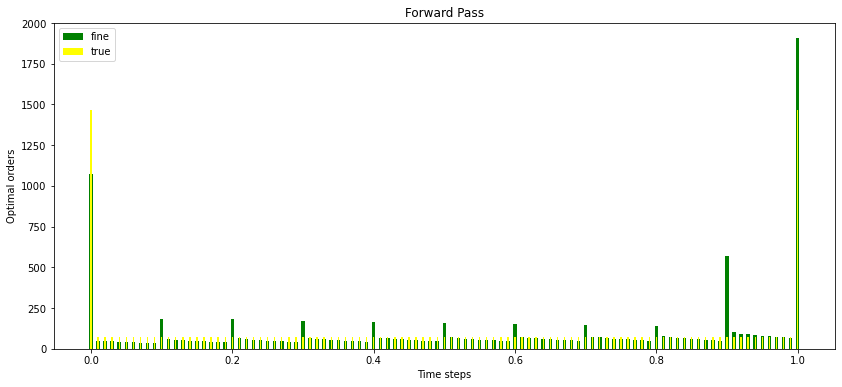

In [ ]:
t_step1=np.linspace(0,1,num=11)
t_step2=np.linspace(0,1,num=101)
plt.figure(figsize=(14,6))
#plt.bar(t_step1,coarse_soln,color='red',width=0.01,label='coarse')
plt.bar(t_step2,fine_soln,color='green',width=0.005,label='fine')
plt.bar(t_step2,true_soln,color='yellow',width=0.002,label='true')
plt.xlabel('Time steps')
plt.ylabel('Optimal orders')
plt.title('Forward Pass')
plt.legend()
plt.show()

In [ ]:
true_cost=cost(true_soln,100)
fine_cost=cost(fine_soln,100)
print('True Cost= %0.2f'% true_cost, 'Fine grid cost= %0.2f'% fine_cost)
error=np.abs(true_cost-fine_cost)
per_error=100*error/true_cost
print('Cost Error= %0.2f'% error)
print('Percentage error= %0.2f'% per_error,'%' )
D_N=data[0,2].detach().numpy()
derivative=kappa*(fine_soln[0])-((10000-sum(fine_soln[i] for i in range(len(fine_soln)-1)))+D_N)
print('\nDerivative of loss with respect to x0 =',derivative)

True Cost= 14287839.92 Fine grid cost= 14883289.83
Cost Error= 595449.91
Percentage error= 4.17 %


NameError: name 'data' is not defined

# Strategy 3: Updated (Adding First and last balance and then doing the forward pass)

In [18]:
def testing_fine_first_last(c_soln,ite):    
    f_soln=[]
    c=c_soln[2]
    x_test=torch.tensor([[0.0,0.0,c[0]]])
    x_test[0,2]=x_test[0,2]+c[ite]
    for i in range(ite):       
        if (i!=0):
            x_test[0,2]=x_test[0,2]+c[i] #Adding previous remaining balance to the current balance         
        for j in range(ite):
            #print(i,x_test)
            soln_pred=model_fin.eval()(x_test).squeeze(1).detach()
            f_soln.append(soln_pred)
            x_test=update(x_test,soln_pred,delta_f)
            #print(x_test[0,2])
    f_soln.append(x_test[0,2].view(1))
    f_soln= np.array([tensor.numpy() for tensor in f_soln]).reshape(len(f_soln))
    return x_test,f_soln

In [19]:
data,fine_soln=testing_fine_first_last(c_soln,ite)
D_N=data[0,2].detach().numpy()
derivative_fin=kappa*(fine_soln[0])-((10000-sum(fine_soln[i] for i in range(len(fine_soln)-1)))+D_N)
derivative_true=kappa*(true_soln[0])-((10000-sum(true_soln[i] for i in range(len(true_soln)-1)))+D_N)
print('\nDerivative of loss func with respect to x0 (True soln) =',derivative_true)
print('\nDerivative of loss func with respect to x0 (Fine soln) =',derivative_fin)
true_soln=closed_form(10000,100)
print('\nFine solution=', fine_soln,'Total=',np.sum(fine_soln))
print('\nTrue solution=', true_soln,'Total=',np.sum(true_soln))
print('\nDifference between true and fine=',(fine_soln-true_soln))



Derivative of loss func with respect to x0 (True soln) = -1488.3808593750198

Derivative of loss func with respect to x0 (Fine soln) = -1444.0829582214355

Fine solution= [1532.6794     70.80138    67.36832    64.189255   61.2411     58.50313
   55.956623   53.584587   51.371674   49.30409   144.04826    76.69533
   70.745      67.26511    64.04509    61.06136    58.29262    55.719543
   53.324776   51.09256   153.40788    77.26732    71.37314    67.84678
   64.58459    61.56238    58.758617   56.153625   53.72979    51.470997
  149.96594    77.70615    71.948494   68.3795     65.07844    62.02095
   59.185097   56.5508     54.100216   51.81701   146.5047     78.12534
   72.50578    68.895035   65.555984   62.463997   59.596615   56.93374
   54.45703    52.150013  143.14767    78.53342    73.05228    69.400246
   66.02376    62.897633   59.999203   57.308125   54.805603   52.475147
  139.88799    78.936775   73.59379    69.90076    66.486984   63.32699
   60.397724   57.678535   55.15

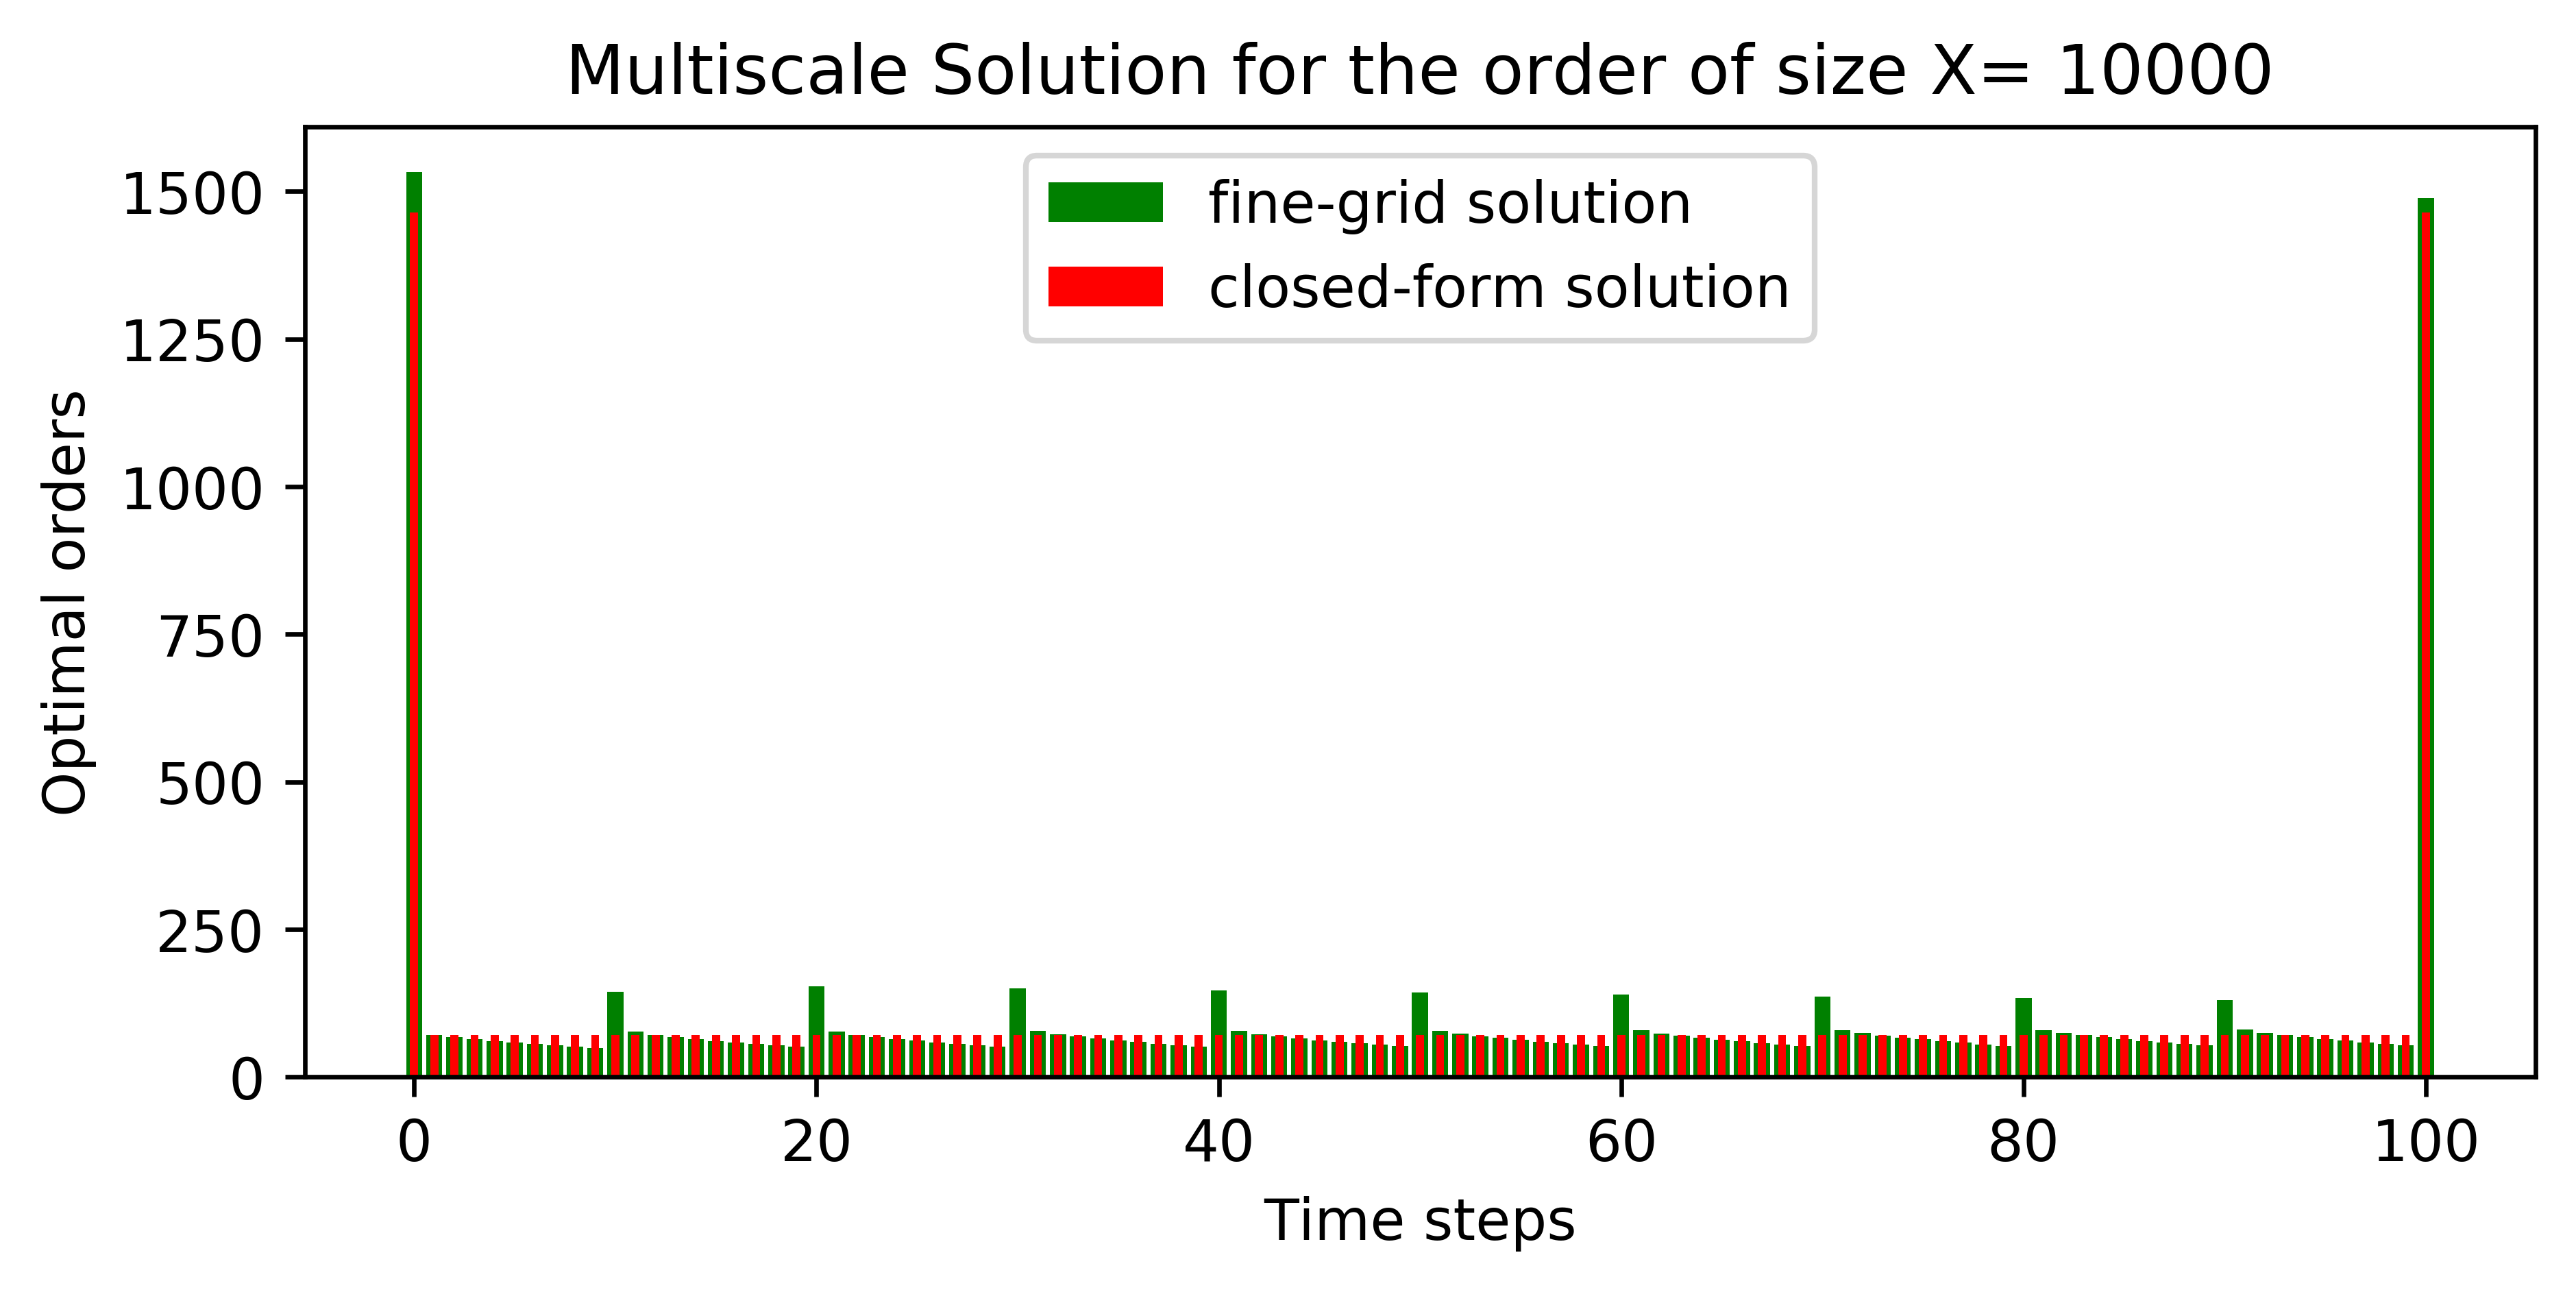

In [32]:
t_step1=np.linspace(0,1,num=11)
t_step2=np.linspace(0,100,num=101)
name='N10_T1_K1_rho5_neo20.eps'
plt.figure(figsize=(7,3),dpi=600)
#plt.bar(t_step1,coarse_soln,color='red',width=0.01,label='coarse')
plt.bar(t_step2,fine_soln,color='green',width=0.8,label='fine-grid solution')
plt.bar(t_step2,true_soln,color='red',width=0.4,label='closed-form solution')
plt.xlabel('Time steps')
plt.ylabel('Optimal orders')
plt.title('Multiscale Solution for the order of size X= %i' % (X0))
plt.legend()
plt.savefig(name,format='eps')  
plt.show()

In [24]:
true_cost=cost(true_soln,100)
fine_cost=cost(fine_soln,100)
print('True Cost= %0.2f'% true_cost, 'Fine grid cost= %0.2f'% fine_cost)
error=np.abs(true_cost-fine_cost)
per_error=100*error/true_cost
print('Cost Error = %0.2f'% error)
print('Percentage Error = %0.2f'% per_error,'%')

True Cost= 14287839.92 Fine grid cost= 14291927.20
Cost Error = 4087.28
Percentage Error = 0.03 %


# The derivative of the loss function

In [ ]:
# The derivative of the loss function with respect to x0 = kappa*x0-[kappa(X-(x0+x1+......+x_{N-1})+DN)]
# 